In [1]:
import pickle
import numpy as np

class SeqDataset(object):

    def __init__(self, ids, features, labels, groups, wordRanges, truePos):
        '''
        ids are ids of candidate sequences

        each row of features is 13 features corresponding to the following:
        feature_0: pred_end - pred_start so length of span -1
        feature_1: normalized start position (normalized by number of words)
        feature_2: normalized end position (normalized by number of words)
        feature_4-10: 7 evenly spaced quantiles of the distribution of relevant class probabilities for this sequence
        feature_11: The probability that words on either edge of the current sub-sequence belong to the class of interest
        feature_12: The probability that the first word corresponds to a 'B'-egin token

        labels are binary labels corresponding to whether the candidate sequence is an exact match to a true span

        wordRanges are the start and end (inclusive on both sides) indices of the candidate sequence

        truePos are binary labels corresponding to whether the candidate sequence would be considered a true positive (>0.5 overlap)

        '''
        self.features = np.array(features, dtype=np.float32)
        self.labels = np.array(labels)
        self.groups = np.array(groups, dtype=np.int16)
        self.wordRanges = np.array(wordRanges, dtype=np.int16)
        self.truePos = np.array(truePos)
        self.ids=ids

In [2]:
import pandas as pd

disc_types = ['Evidence','Claim','Lead','Position','Counterclaim','Rebuttal','Concluding Statement']

dfs = []

folder= 'cache' #put pickle files in this folder
for fold in range(8):
    with open(f'{folder}/valid_seqds_fold{fold}.p','rb') as f:
        seqdataset=pickle.load(f)
        
        for disc_type in disc_types:
            x = seqdataset[disc_type]

            df = pd.DataFrame()
            df[[f"f_{i}" for i in range(x.features.shape[1])]] = x.features
            df["id"] = x.ids
            df["class"] = disc_type
            df[["begin", "end"]] = x.wordRanges
            df["kfold"] = fold
            
            dfs.append(df)
            
            
len_features = x.features.shape[1]

In [3]:
oof_df = pd.concat(dfs)
print(oof_df.shape)
oof_df.head()

(31992957, 39)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_29,f_30,f_31,f_32,f_33,id,class,begin,end,kfold
0,1.0,0.183223,0.185430,0.996201,0.996201,0.996201,0.996201,0.996201,0.996201,0.996201,...,-0.183223,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,84,0
1,2.0,0.183223,0.187638,0.996201,0.996581,0.996961,0.997341,0.997721,0.998101,0.998481,...,-0.183223,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,85,0
2,3.0,0.183223,0.189845,0.996201,0.996961,0.997721,0.998481,0.998793,0.999105,0.999417,...,-0.183223,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,86,0
3,4.0,0.183223,0.192053,0.996201,0.997341,0.998481,0.998949,0.999417,0.999611,0.999805,...,-0.183223,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,87,0
4,5.0,0.183223,0.194260,0.996201,0.997721,0.998793,0.999417,0.999583,0.999712,0.999805,...,-0.183223,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,88,0


In [4]:
oof_df.sample(3, random_state=0).T

,1893165,845375,1561991
f_0,33.0,234.0,9.0
f_1,0.624502,0.261084,0.175258
f_2,0.657371,0.837438,0.206186
f_3,0.472124,0.000068,0.081796
f_4,0.534002,0.992032,0.084331
f_5,0.544125,0.99913,0.084575
f_6,0.551453,0.999516,0.085622
f_7,0.99493,0.999521,0.088843
f_8,0.995468,0.999712,0.093662
f_9,0.997467,1.000012,0.211576


In [5]:
gt_df = pd.read_csv("../train_folds.csv")
print(gt_df.shape)
gt_df.head()

(144293, 9)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,1
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,1
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,1


In [6]:
from tqdm import tqdm


ps = []

for begin, end in tqdm(list(zip(oof_df["begin"].values, oof_df["end"].values))):
    ps.append(" ".join([str(int(x)) for x in range(begin, end)]))

oof_df["predictionstring"] = ps

100%|█████████████████████████████████████████████████| 31992957/31992957 [08:20<00:00, 63965.81it/s]


In [7]:
oof_df.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_30,f_31,f_32,f_33,id,class,begin,end,kfold,predictionstring
0,1.0,0.183223,0.185430,0.996201,0.996201,0.996201,0.996201,0.996201,0.996201,0.996201,...,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,84,0,83
1,2.0,0.183223,0.187638,0.996201,0.996581,0.996961,0.997341,0.997721,0.998101,0.998481,...,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,85,0,83 84
2,3.0,0.183223,0.189845,0.996201,0.996961,0.997721,0.998481,0.998793,0.999105,0.999417,...,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,86,0,83 84 85
3,4.0,0.183223,0.192053,0.996201,0.997341,0.998481,0.998949,0.999417,0.999611,0.999805,...,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,87,0,83 84 85 86
4,5.0,0.183223,0.194260,0.996201,0.997721,0.998793,0.999417,0.999583,0.999712,0.999805,...,-0.119205,0.737307,0.790287,0.668874,4AB030046F42,Evidence,83,88,0,83 84 85 86 87


In [8]:
from utils import score_feedback_comp


sample_df = oof_df[oof_df["f_7"] > 0.9999].reset_index(drop=True)
print(sample_df.shape)

score_feedback_comp(sample_df, gt_df, return_class_scores=True)

(222210, 40)


(0.0033459303983092437,
 {'Claim': 0.0,
  'Concluding Statement': 0.0,
  'Counterclaim': 0.0,
  'Evidence': 0.010674047795407586,
  'Lead': 0.012747464992757121,
  'Position': 0.0,
  'Rebuttal': 0.0})

In [9]:
oof_df["idx"] = np.arange(oof_df.shape[0])

eval_df = oof_df[["idx", "id", "class", "predictionstring"]].merge(gt_df[["id", "discourse_type", "predictionstring"]].rename(columns={"predictionstring": "gt_ps",
                                                                                          "discourse_type": 'class'}), 
                      how="left", on=["id", "class"])
eval_df.shape

(89962432, 5)

In [10]:
def calc_overlap(predictionstring, gt_ps):

    set_pred = set(str(predictionstring).split(" "))
    set_gt = set(str(gt_ps).split(" "))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter / len_pred
    return min(overlap_1, overlap_2)



overlap = []

for predictionstring, gt_ps in tqdm(list(zip(eval_df["predictionstring"].values, eval_df["gt_ps"].values))):
    overlap.append(calc_overlap(predictionstring, gt_ps))
    
    
eval_df["overlap"] = overlap

100%|█████████████████████████████████████████████████| 89962432/89962432 [16:46<00:00, 89350.28it/s]


In [11]:
eval_df = eval_df.groupby("idx")["overlap"].max().reset_index()
eval_df.shape

(31992957, 2)

In [12]:
eval_df.head()

,idx,overlap
0,0,0.011628
1,1,0.023256
2,2,0.034884
3,3,0.046512
4,4,0.058140


In [13]:
eval_df.tail()

,idx,overlap
31992952,31992952,0.329412
31992953,31992953,0.341176
31992954,31992954,0.352941
31992955,31992955,0.364706
31992956,31992956,0.376471


In [14]:
oof_df.head()["idx"], oof_df.tail()["idx"]

(0    0
 1    1
 2    2
 3    3
 4    4
 Name: idx, dtype: int64,
 157575    31992952
 157576    31992953
 157577    31992954
 157578    31992955
 157579    31992956
 Name: idx, dtype: int64)

<AxesSubplot:>

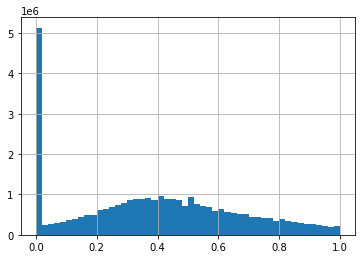

In [15]:
oof_df["overlap"] = eval_df["overlap"].values

oof_df["overlap"].fillna(0.0, inplace=True)

oof_df["overlap"].hist(bins=50)

In [16]:
oof_df.to_parquet(f"{folder}/new_oof_ensemble.parquet", index=False)